In [1]:
# Importing necessary libraries
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
# Stablishing connection and creating engine with Mysql 
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.film_id, f.language_id, f.rental_rate, f.length, f.rating, f.special_features,fc.category_id, COUNT(r.rental_date) AS num_rentals
FROM sakila.film AS f
LEFT JOIN sakila.film_category as fc USING (film_id)
LEFT JOIN inventory AS i USING (film_id)
LEFT JOIN rental AS r USING (inventory_id)
GROUP BY f.film_id, fc.category_id;'''
data = pd.read_sql_query(query, engine)
data.head()

,film_id,language_id,rental_rate,length,rating,special_features,category_id,num_rentals
0,1,1,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6,23
1,2,1,4.99,48,G,"Trailers,Deleted Scenes",11,7
2,3,1,2.99,50,NC-17,"Trailers,Deleted Scenes",6,12
3,4,1,2.99,117,G,"Commentaries,Behind the Scenes",11,23
4,5,1,2.99,130,G,Deleted Scenes,8,12


In [3]:
# Checking for the shape
data.shape

(1000, 8)

In [4]:
# Checking the for the unique film titles and confirming the 1000 rows expected
unique_film_titles_count = data['film_id'].nunique()
print(f"Number of unique film titles: {unique_film_titles_count}")

Number of unique film titles: 1000


In [5]:
# Check the number of duplicates
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate records: {duplicate_count}")

Number of duplicate records: 0


In [6]:
# Checking for film availability _ new query
query1 ='''SELECT DISTINCT f.film_id AS film_id,
CASE
WHEN IFNULL(i.inventory_id, 0) = 0 THEN 'NOT available'
ELSE 'Available'
END AS availability_status
FROM sakila.film AS f
LEFT JOIN sakila.inventory AS i
ON f.film_id = i.film_id;'''

data1 = pd.read_sql_query(query1, engine)
data1.head()

,film_id,availability_status
0,1,Available
1,2,Available
2,3,Available
3,4,Available
4,5,Available


In [7]:
# Merging both tables, from query and query1
data_new = data.merge(data1, on='film_id', how='left')
data_new

,film_id,language_id,rental_rate,length,rating,special_features,category_id,num_rentals,availability_status
0,1,1,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6,23,Available
1,2,1,4.99,48,G,"Trailers,Deleted Scenes",11,7,Available
2,3,1,2.99,50,NC-17,"Trailers,Deleted Scenes",6,12,Available
3,4,1,2.99,117,G,"Commentaries,Behind the Scenes",11,23,Available
4,5,1,2.99,130,G,Deleted Scenes,8,12,Available
...,...,...,...,...,...,...,...,...,...
995,996,1,0.99,183,G,"Trailers,Behind the Scenes",6,7,Available
996,997,1,0.99,179,NC-17,"Trailers,Behind the Scenes",12,6,Available
997,998,1,0.99,105,NC-17,Deleted Scenes,11,9,Available
998,999,1,2.99,101,R,"Trailers,Deleted Scenes",3,17,Available


In [8]:
# Quering about the films rented in May 2005
query2 = '''SELECT
    f.film_id,
    MAX(CASE WHEN r.rental_date >= '2005-05-01' AND r.rental_date < '2005-06-01' THEN 1 ELSE 0 END) AS rented_in_may
FROM
    sakila.film AS f
LEFT JOIN
    sakila.inventory AS i ON f.film_id = i.film_id
LEFT JOIN
    sakila.rental AS r ON i.inventory_id = r.inventory_id
GROUP BY
    f.film_id;'''
data2 = pd.read_sql_query(query2, engine)
data2.head()

,film_id,rented_in_may
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


In [9]:
# Checking for data shape
data2.shape

(1000, 2)

In [10]:
# Merging both tables, from data_new and query2
final_data = data_new.merge(data2, on='film_id', how='left')
final_data

,film_id,language_id,rental_rate,length,rating,special_features,category_id,num_rentals,availability_status,rented_in_may
0,1,1,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6,23,Available,1
1,2,1,4.99,48,G,"Trailers,Deleted Scenes",11,7,Available,0
2,3,1,2.99,50,NC-17,"Trailers,Deleted Scenes",6,12,Available,1
3,4,1,2.99,117,G,"Commentaries,Behind the Scenes",11,23,Available,1
4,5,1,2.99,130,G,Deleted Scenes,8,12,Available,1
...,...,...,...,...,...,...,...,...,...,...
995,996,1,0.99,183,G,"Trailers,Behind the Scenes",6,7,Available,0
996,997,1,0.99,179,NC-17,"Trailers,Behind the Scenes",12,6,Available,0
997,998,1,0.99,105,NC-17,Deleted Scenes,11,9,Available,1
998,999,1,2.99,101,R,"Trailers,Deleted Scenes",3,17,Available,1


In [11]:
# Convert the 'column_name' from 0s and 1s to boolean values
final_data['rented_in_may'] = final_data['rented_in_may'].astype(bool)
final_data

,film_id,language_id,rental_rate,length,rating,special_features,category_id,num_rentals,availability_status,rented_in_may
0,1,1,0.99,86,PG,"Deleted Scenes,Behind the Scenes",6,23,Available,True
1,2,1,4.99,48,G,"Trailers,Deleted Scenes",11,7,Available,False
2,3,1,2.99,50,NC-17,"Trailers,Deleted Scenes",6,12,Available,True
3,4,1,2.99,117,G,"Commentaries,Behind the Scenes",11,23,Available,True
4,5,1,2.99,130,G,Deleted Scenes,8,12,Available,True
...,...,...,...,...,...,...,...,...,...,...
995,996,1,0.99,183,G,"Trailers,Behind the Scenes",6,7,Available,False
996,997,1,0.99,179,NC-17,"Trailers,Behind the Scenes",12,6,Available,False
997,998,1,0.99,105,NC-17,Deleted Scenes,11,9,Available,True
998,999,1,2.99,101,R,"Trailers,Deleted Scenes",3,17,Available,True


In [12]:
final_data.dtypes

film_id                  int64
language_id              int64
rental_rate            float64
length                   int64
rating                  object
special_features        object
category_id              int64
num_rentals              int64
availability_status     object
rented_in_may             bool
dtype: object

In [13]:
final_data.describe()

,film_id,language_id,rental_rate,length,category_id,num_rentals
count,1000.000000,1000.0,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,1.0,2.980000,115.272000,8.47800,16.044000
std,288.819436,0.0,1.646393,40.426332,4.61029,7.348065
min,1.000000,1.0,0.990000,46.000000,1.00000,0.000000
25%,250.750000,1.0,0.990000,80.000000,5.00000,11.000000
50%,500.500000,1.0,2.990000,114.000000,8.00000,16.000000
75%,750.250000,1.0,4.990000,149.250000,13.00000,21.000000
max,1000.000000,1.0,4.990000,185.000000,16.00000,34.000000


In [14]:
final_data['language_id'].value_counts()

1    1000
Name: language_id, dtype: int64

In [15]:
unique_values = final_data['language_id'].unique()
unique_values

array([1], dtype=int64)

In [16]:
# Checking correlations
import matplotlib.pyplot as plt
import seaborn as sns

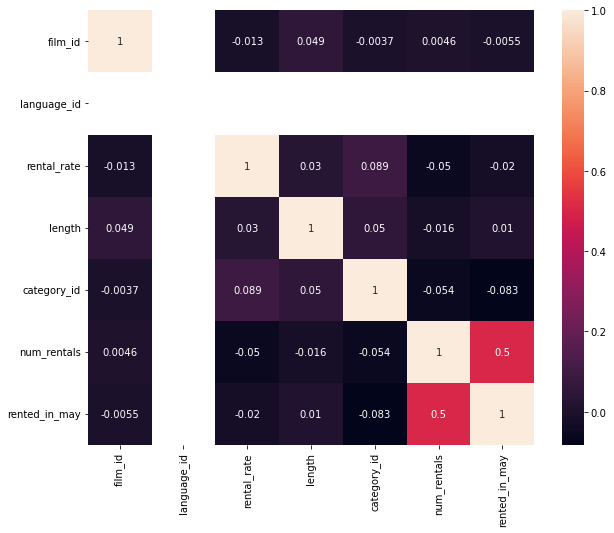

In [17]:
corr_matrix=final_data.corr()  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [18]:
final_data = final_data.drop(['film_id','language_id', 'special_features', 'availability_status'], axis=1)

In [19]:
final_data

,rental_rate,length,rating,category_id,num_rentals,rented_in_may
0,0.99,86,PG,6,23,True
1,4.99,48,G,11,7,False
2,2.99,50,NC-17,6,12,True
3,2.99,117,G,11,23,True
4,2.99,130,G,8,12,True
...,...,...,...,...,...,...
995,0.99,183,G,6,7,False
996,0.99,179,NC-17,12,6,False
997,0.99,105,NC-17,11,9,True
998,2.99,101,R,3,17,True


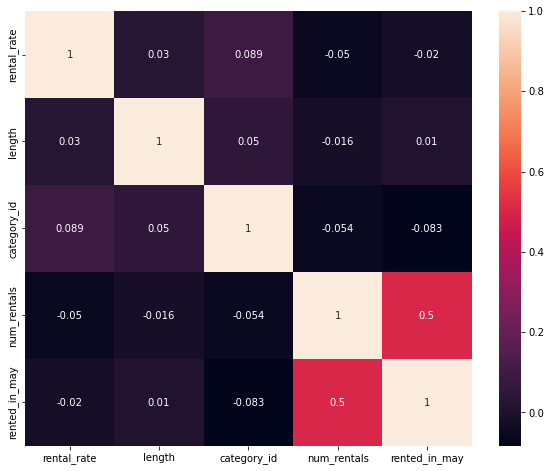

In [20]:
corr_matrix=final_data.corr()  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

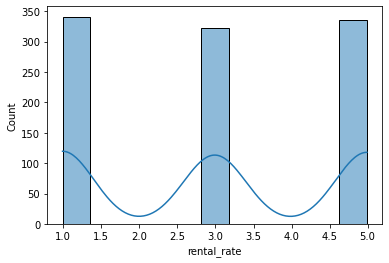

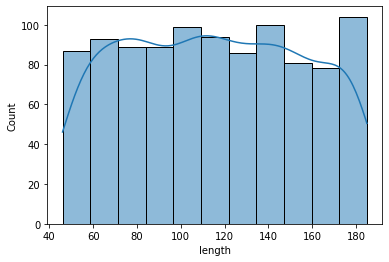

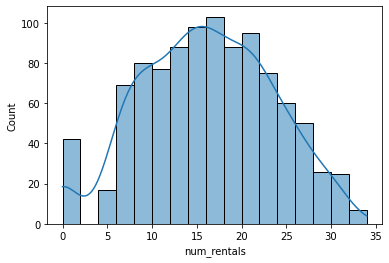

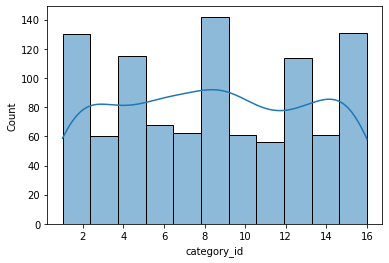

In [21]:
# look at the scale and distribution of values
sns.histplot(final_data['rental_rate'], kde=True)
plt.show()

sns.histplot(final_data['length'], kde=True)
plt.show()

sns.histplot(final_data['num_rentals'], kde=True)
plt.show()

sns.histplot(final_data['category_id'], kde=True)
plt.show()

In [22]:
# X-y split 
y = final_data['rented_in_may']
X = final_data.drop('rented_in_may', axis=1)

In [23]:
y.head()

0     True
1    False
2     True
3     True
4     True
Name: rented_in_may, dtype: bool

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [25]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Splititng in categorical and numerical data
X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat  = X_test.select_dtypes(include = object)

In [26]:
# Scaling data
transformer = MinMaxScaler().fit(X_train_num)
x_normalized = transformer.transform(X_train_num)
x_norm = pd.DataFrame(x_normalized, columns=X_train_num.columns)
x_norm.head()

,rental_rate,length,category_id,num_rentals
0,0.0,0.309353,0.800000,0.882353
1,0.5,0.172662,0.933333,0.794118
2,0.0,0.100719,0.000000,0.705882
3,0.5,0.892086,0.466667,0.705882
4,0.5,1.000000,0.000000,0.470588


In [27]:
# OneHotEncoding of the categorical data
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first').fit(X_train_cat)  # Fiting and Dropping the first varaible of each column
encoded = encoder.transform(X_train_cat).toarray()
column_names = encoder.get_feature_names_out(input_features=X_train_cat.columns) # assigning column names
onehot_encoded = pd.DataFrame(encoded, columns=column_names)
onehot_encoded.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [28]:
# Concatenating DataFrames - getting both dataframes together again
X_train_treated = pd.concat([x_norm, onehot_encoded], axis=1)
X_train_treated

,rental_rate,length,category_id,num_rentals,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.309353,0.800000,0.882353,0.0,0.0,0.0,0.0
1,0.5,0.172662,0.933333,0.794118,0.0,0.0,0.0,1.0
2,0.0,0.100719,0.000000,0.705882,0.0,1.0,0.0,0.0
3,0.5,0.892086,0.466667,0.705882,0.0,0.0,0.0,0.0
4,0.5,1.000000,0.000000,0.470588,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
795,0.5,0.834532,0.866667,0.617647,0.0,0.0,0.0,1.0
796,0.5,0.474820,0.933333,0.764706,1.0,0.0,0.0,0.0
797,0.5,0.856115,0.000000,0.352941,0.0,0.0,1.0,0.0
798,0.5,0.309353,0.066667,0.264706,0.0,0.0,1.0,0.0


In [29]:
# Using multinomial logistic regression
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_treated, y_train)

In [30]:
# Checking for equality of data on X_train_cat and y_train_cat, despite of not have choosen 'get dummies' in the encoding
list(X_train_cat.columns)==list(X_test_cat.columns)

True

In [31]:
# Getting both indexes matching after the scalling
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [32]:
# Checking for index values match
y_train.head()

0    True
1    True
2    True
3    True
4    True
Name: rented_in_may, dtype: bool

In [33]:
y_test.head()

0     True
1    False
2    False
3    False
4     True
Name: rented_in_may, dtype: bool

In [34]:
X_test_num.head()

,rental_rate,length,category_id,num_rentals
492,0.99,92,9,14
383,4.99,49,12,8
856,2.99,144,5,23
834,2.99,112,10,27
603,0.99,160,5,13


In [35]:
# apply scaler to X_test_num
X_test_scaled_arr = transformer.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=X_test_num.columns)
X_test_scaled.head()

,rental_rate,length,category_id,num_rentals
0,0.0,0.330935,0.533333,0.411765
1,1.0,0.021583,0.733333,0.235294
2,0.5,0.705036,0.266667,0.676471
3,0.5,0.474820,0.600000,0.794118
4,0.0,0.820144,0.266667,0.382353


In [36]:
# Getting the stats
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
rental_rate,200.0,3.070,1.675601,0.99,0.99,2.99,4.99,4.99
length,200.0,118.485,39.613076,47.00,85.75,115.00,151.00,185.00
category_id,200.0,8.595,4.504713,1.00,5.00,8.00,13.00,16.00
num_rentals,200.0,16.110,7.427228,0.00,10.00,16.00,22.00,32.00


In [37]:
# apply encoder to X_test_cat 
encoded_test_cat = encoder.transform(X_test_cat).toarray()
onehot_encoded_test = pd.DataFrame(encoded_test_cat, columns=column_names)
onehot_encoded_test.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0


In [38]:
# Concatenate both scaled and onehot_encoded portions of X_test
X_test_treated = pd.concat([X_test_scaled, onehot_encoded_test], axis=1)
X_test_treated

,rental_rate,length,category_id,num_rentals,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.330935,0.533333,0.411765,0.0,0.0,0.0,1.0
1,1.0,0.021583,0.733333,0.235294,0.0,0.0,0.0,1.0
2,0.5,0.705036,0.266667,0.676471,0.0,0.0,1.0,0.0
3,0.5,0.474820,0.600000,0.794118,0.0,0.0,1.0,0.0
4,0.0,0.820144,0.266667,0.382353,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
195,0.5,0.748201,0.866667,0.852941,0.0,0.0,1.0,0.0
196,0.0,0.877698,0.400000,0.235294,1.0,0.0,0.0,0.0
197,1.0,0.460432,0.266667,0.647059,0.0,1.0,0.0,0.0
198,0.0,0.165468,0.200000,0.205882,0.0,0.0,0.0,0.0


In [39]:
# Using multinomial logistic regression
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_test_treated, y_test)

In [65]:
# Predict and get the prediction score
predictions = classification.predict(X_test_treated)
classification.score(X_test_treated, y_test)

0.735

In [41]:
# Check the values in test
y_test.value_counts()

True     133
False     67
Name: rented_in_may, dtype: int64

In [42]:
# Check the predicted values
pd.Series(predictions).value_counts()

True     160
False     40
dtype: int64

In [43]:
# Condusion _matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 27,  40],
       [ 13, 120]], dtype=int64)

In [44]:
# predicted |  T | F  | 
# ---------------------
# actual  T | 27 | 40 |  
# ---------------------
#         F | 13 | 120| 
# --------------------

In [45]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("precision: ",precision_score(y_test,predictions))
print("recall: ",recall_score(y_test,predictions))
print("f1: ",f1_score(y_test,predictions))

precision:  0.75
recall:  0.9022556390977443
f1:  0.8191126279863481


In [46]:
# accuracy check
accuracy = (27+120)/len(predictions)
accuracy

0.735

In [47]:
# Checking with another logistic regression model - KNN classifier

In [48]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform')
clf.fit(X_test_treated, y_test)

KNeighborsClassifier(n_neighbors=3)

In [49]:
# Predict and get the prediction score
predictions_clf = clf.predict(X_test_treated)
clf.score(X_test_treated, y_test)

0.8

In [50]:
# Check the values in test
y_test.value_counts()

True     133
False     67
Name: rented_in_may, dtype: int64

In [51]:
# Check the predicted values
pd.Series(predictions_clf).value_counts()

True     145
False     55
dtype: int64

In [52]:
# Condusion _matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions_clf)

array([[ 41,  26],
       [ 14, 119]], dtype=int64)

In [53]:
# predicted |T | F | 
# ---------------------
# actual  T | 41 | 26 |  
# ---------------------
#         F | 14 | 119| 
# ---------------------


In [54]:
print("precision: ",precision_score(y_test,predictions_clf))
print("recall: ",recall_score(y_test,predictions_clf))
print("f1: ",f1_score(y_test,predictions_clf))

precision:  0.8206896551724138
recall:  0.8947368421052632
f1:  0.8561151079136691


In [55]:
# Calculate the accuracy of the model:
# Accuracy = (True Positive + False Positive)/ All predictions
Accuracy = (41 + 119)/200
Accuracy

0.8

In [56]:
# For this model, I have choosen the multinomial ate the beggining, because it has more than one class envolved.
# Prediction score was 0.73 and despite of having a good recall value of 0.90 I decided to apply other logistic regression model.
# I tried with the KNN classifier, which return a higher prediction score than before - 0,8.
# In general I consider that is a good predictive model.